<a href="https://colab.research.google.com/github/vsoos/DeepLearning/blob/main/ex4/BaseEnergyTwoRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimpleRNN for time series forecasting

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm.keras import TqdmCallback

seed = 101
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_4/"
os.chdir(folder_path)

In [ ]:
df_txt = pd.read_csv("data/household_power_consumption.txt", sep=";", na_values="NaN", low_memory=False)

In [ ]:
df_txt['datetime'] = pd.to_datetime(df_txt['Date'] + ' ' + df_txt['Time'])
df_txt.drop(columns=['Date', 'Time'], inplace=True)

In [ ]:
df = df_txt

In [ ]:
df = df.sort_values(by='datetime')
df.columns = df.columns.str.lower()
df.head(5)

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,datetime
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.reset_index(inplace=True)
df = df[['datetime', 'global_active_power']]
df.head(2)

,datetime,global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360


In [ ]:
df['global_active_power'] = pd.to_numeric(df['global_active_power'], errors='coerce')
df.dropna(subset=['global_active_power'], inplace=True)

In [ ]:
df.set_index('datetime', inplace=True)
df_resampled = df['global_active_power'].resample('D').mean()

In [ ]:
df_resampled.dropna(inplace=True)
df_resampled.isna().sum()

0

In [ ]:
df_resampled.head()

,global_active_power
datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


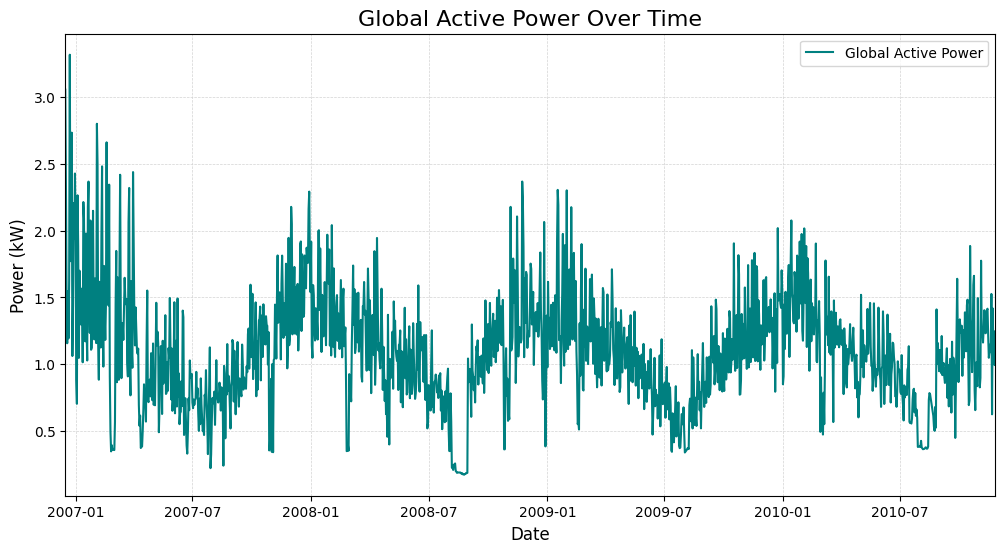

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_resampled, color='teal', label='Global Active Power', linewidth=1.5)
plt.title('Global Active Power Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.xlim(df_resampled.index.min(), df_resampled.index.max())  # Fix x-axis limits
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend(fontsize=10)
plt.show()

In [ ]:
df_resampled = df_resampled.reset_index()  # Reset index after resampling
df_resampled.head(2)

,datetime,global_active_power
0,2006-12-16,3.053475
1,2006-12-17,2.354486


# prep

In [ ]:
data = df_resampled[['global_active_power']].values

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0.01, 1))
data_normalized = scaler.fit_transform(data)

In [ ]:
print(np.isnan(data).any())

False


In [ ]:
# 80% train, 20% test
train_size = int(len(data_normalized) * 0.8)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

#TimeseriesGenerator

In [ ]:
TimeseriesGenerator = tf.keras.preprocessing.sequence.TimeseriesGenerator

In [ ]:
# number of previous steps to predict the next one
look_back = 20
n_features = 1

In [ ]:
train_generator = TimeseriesGenerator(train_data, train_data, length=look_back, batch_size=1)
test_generator = TimeseriesGenerator(test_data, test_data, length=look_back, batch_size=1)

# RNN model

In [ ]:
Sequential = tf.keras.models.Sequential
LSTM = tf.keras.layers.LSTM
Dense = tf.keras.layers.Dense
Input = tf.keras.layers.InputLayer
SimpleRNN = tf.keras.layers.SimpleRNN

In [ ]:
n_neurons = 20
model = tf.keras.Sequential([
    Input(shape=(look_back, n_features)),
    SimpleRNN(n_neurons, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    train_generator,
    epochs=50,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

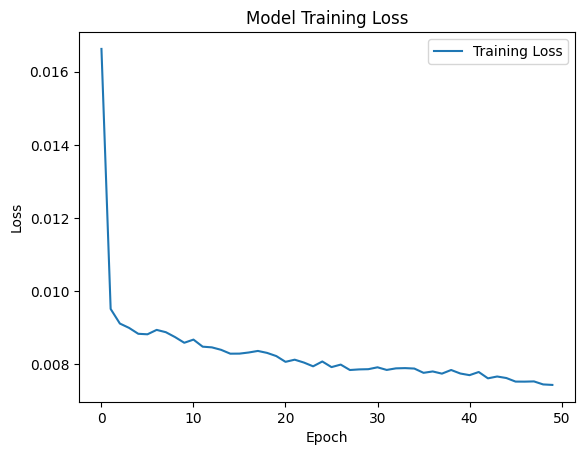

In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate

In [ ]:
# predictions
train_predictions = model.predict(train_generator)
test_predictions = model.predict(test_generator)

1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# rescale predictions and actual values back to original scale
train_predictions_rescaled = scaler.inverse_transform(train_predictions)
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
train_actual_rescaled = scaler.inverse_transform(train_data[look_back:])
test_actual_rescaled = scaler.inverse_transform(test_data[look_back:])

In [ ]:
# metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, mse, rmse, r2, mape

In [ ]:
train_metrics = calculate_metrics(train_actual_rescaled, train_predictions_rescaled)
test_metrics = calculate_metrics(test_actual_rescaled, test_predictions_rescaled)

In [ ]:
metrics_data = {
    "Metric": ["MAE", "MSE", "RMSE", "R2", "MAPE"],
    "Train": train_metrics,
    "Test": test_metrics
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Metric,Train,Test
0,MAE,0.200801,0.184791
1,MSE,0.072960,0.064815
2,RMSE,0.270112,0.254589
3,R2,0.592825,0.295379
4,MAPE,20.297423,20.120973


# forcasting

In [ ]:
# last look_back values from the test set
seed_batch = test_data[-look_back:].reshape((1, look_back, n_features))
current_batch = seed_batch
future_predictions = []

In [ ]:
for i in range(100): # 100 future time steps
    prediction = model.predict(current_batch, verbose=0)[0]
    future_predictions.append(prediction)
    # Update the batch with the predicted value
    current_batch = np.append(current_batch[:, 1:, :], [[prediction]], axis=1)

In [ ]:
# rescale predictions back to the original scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

In [ ]:
df.reset_index(inplace=True)

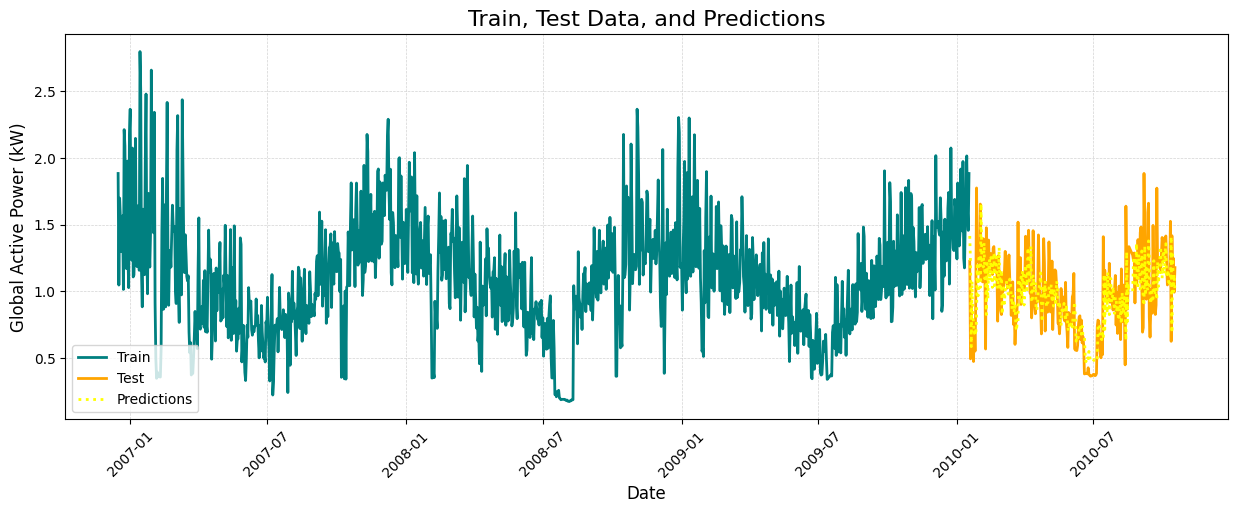

In [ ]:
# Prepare data with datetime for visualization
train_dates = df_resampled['datetime'][:len(train_actual_rescaled)]
test_dates = df_resampled['datetime'][len(train_actual_rescaled):len(train_actual_rescaled) + len(test_actual_rescaled)]

# Plotting
plt.figure(figsize=(15, 5))

# Plot training data
plt.plot(train_dates, train_actual_rescaled, label='Train', linewidth=2, color='Teal')

# Plot test data
plt.plot(test_dates, test_actual_rescaled, label='Test', linewidth=2, color='orange')

# Plot predictions
plt.plot(test_dates, test_predictions_rescaled, label='Predictions', linestyle=':', linewidth=2, color='yellow')

# Add labels, legend, and format the x-axis
plt.title("Train, Test Data, and Predictions", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Global Active Power (kW)", fontsize=12)
plt.legend(loc="lower left", fontsize=10)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()
